In [76]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import scipy
import pandas as pd

### Generate Samples

In [237]:
def sample_normal(a_0, b_0, kappa_0, mu_0, N):
    ''' Sample from a univariate normal distribution with normal, inv-gamma priors:
    
        tau ~ Gamma(a_0, b_0)
        mu ~ N(mu_0, (kappa_0 * tau)^-1)
        X ~ N(mu, tau^-1)
    
    '''
    tau = np.random.gamma(a_0, 1.0 / b_0, N)
    mu = np.random.normal(mu_0, 1. / (kappa_0 * tau))
    x = np.random.normal(mu, 1. / tau)
   
    return pd.DataFrame({'tau': tau, 'mu': mu, 'x': x})


a_0 = 9.0
b_0 = 1.5
kappa_0 = 1.0
mu_0 = 10.0
N=10000

df = sample_normal(a_0, b_0, kappa_0, mu_0, N)
df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

,mu,tau,x
count,10000.000000,10000.000000,10000.000000
mean,9.996974,6.010073,9.998252
std,0.197529,1.986607,0.283269
min,8.868218,1.331673,8.333208
5%,9.681737,3.123228,9.549230
25%,9.883356,4.579354,9.836677
50%,9.997508,5.785451,10.000371
75%,10.111119,7.226427,10.162363
95%,10.313272,9.535857,10.443691
max,11.205364,16.267770,12.656569


### Take a look at the distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4b91785be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f4b92121780>]], dtype=object)

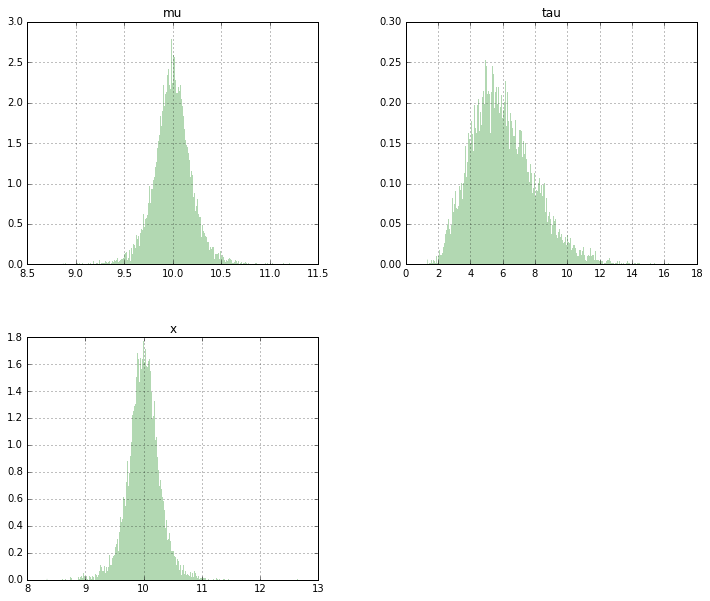

In [238]:
df.hist(bins=300, normed=True, color='green', alpha=0.3, linewidth=0.0, figsize=(12, 10))

### Compute the mean-field approximation

In [245]:
def mean_field(x, a_0, b_0, kappa_0, mu_0, N, etol=1e-8):
    mu_n = (kappa_0 * mu_0 + N * x.mean()) / (kappa_0 + N)
    E_q_mu = mu_n
    kappa_n = 1.
    a_n = a_0 + (N + 1.) / 2.
    b_n = 1.
    
    for n in range(1, 1000):
        E_q_mu2 = 1. / kappa_n + mu_n**2
        
        b_old = b_n
        #b_n = (b_0 + 
        #     kappa_0 * (E_q_mu2 + mu_0 ** 2 - 2 * E_q_mu * mu_0) +
        #     0.5 * ((x**2).sum() + N * E_q_mu2 - 2 * E_q_mu * x.sum()))
        b_n = b_0 + 0.5 * ((kappa_0 + N) * (1. / kappa_n + mu_n**2) 
                         - 2 * (kappa_0 * mu_0 + x.sum()) * mu_n
                         + (x**2).sum() + lambda_0 * mu_0 **2)
        
        kappa_old = kappa_n
        kappa_n = (kappa_0 + N) * a_n / b_n
        
        if abs(b_n - b_old) + abs(kappa_n - kappa_old) < etol:
            break
            
    print ("Finished after %d iterations" % n)
    
    return a_n, b_n, kappa_n, mu_n

a_n, b_n, kappa_n, mu_n = mean_field(df['x'], a_0, b_0, kappa_0, mu_0, N)
(a_n, b_n, kappa_n, mu_n)

Finished after 6 iterations


(5009.5, 402.70548729837174, 124408.55930746233, 9.9982525557618533)

### Compare Exact Samples with Mean-Field Approximation

[  9.99822772  10.00122231  10.00421689  10.00721148  10.01020607
  10.01320066  10.01619525  10.01918984  10.02218443  10.02517902]
[ 12.96287112  12.96586571  12.9688603   12.97185489  12.97484948
  12.97784406  12.98083865  12.98383324  12.98682783  12.98982242]
                  gamma        norm
9.998228   1.290891e-48  418.894826
10.001222  1.731999e-48    0.000000
10.004217  2.322794e-48    0.000000
10.007211  3.113716e-48    0.000000
10.010206  4.172078e-48    0.000000


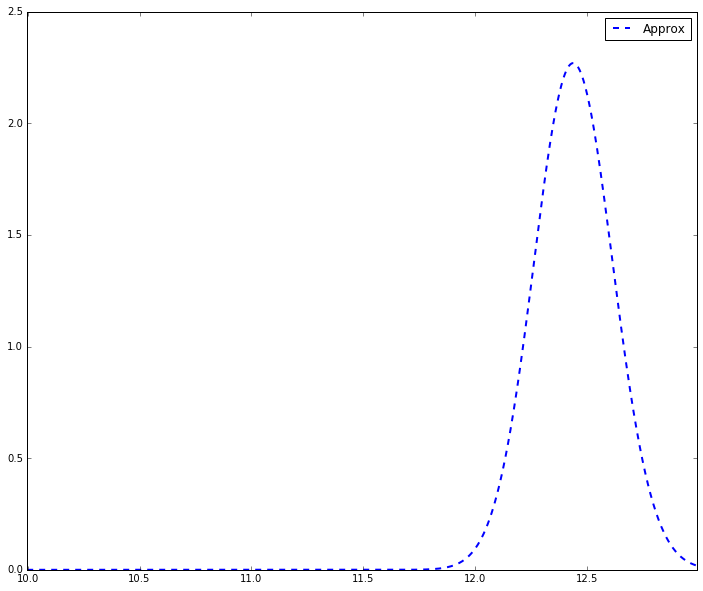

In [246]:
import scipy.stats as stats

gamma = stats.gamma(a=a_n, scale=1. / b_n)
#gamma = stats.gamma(a=2, scale=3)
norm = stats.norm(loc=mu_n, scale=1. / kappa_n)

x = np.linspace(min(gamma.ppf(0.001), norm.ppf(0.001)), 
                max(gamma.ppf(0.999), norm.ppf(0.999)), 1000)
print(x[:10])
print(x[-10:])
gamma_samples = gamma.pdf(x)
norm_samples = norm.pdf(x)

approx = pd.DataFrame({'gamma': gamma_samples, 'norm': norm_samples}, index=x)

print(approx.head())

# Plot Histogram vs. Target PDF
approx['gamma'].plot(color='blue', style='--', figsize=(12,10), linewidth=2.0)
#pd.Series(df['tau']).hist(bins=300, normed=True, color='green',  alpha=0.3, linewidth=0.0)
#approx['norm'].plot(color='blue', style='--', figsize=(12,10), linewidth=2.0)
#pd.Series(df['mu']).hist(bins=300, normed=True, color='green',  alpha=0.3, linewidth=0.0)
plt.legend(['Approx', 'Exact Samples'])
plt.show()